In [1]:
from functools import partial
from random import expovariate, sample

import os

import numpy as np
import simpy
import pandas as pd

import networkx as nx

from ns.packet.dist_generator import DistPacketGenerator
from ns.packet.trace_generator import TracePacketGenerator
from ns.packet.sink import PacketSink
from ns.switch.switch import SimplePacketSwitch
from ns.switch.switch import FairPacketSwitch
from ns.topos.fattree import build as build_fattree
from ns.topos.utils import generate_fib, generate_flows, read_topo

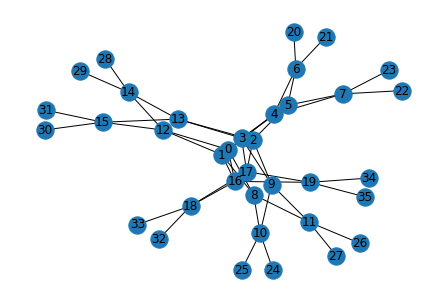

In [2]:
env = simpy.Environment()

mean_pkt_size=10
pir = 100000
buffer_size = 1000

k = 4
ft = build_fattree(k)

nx.draw(ft, with_labels=True)

In [3]:

hosts = set()
for n in ft.nodes():
    if ft.nodes[n]['type'] == 'host':
        hosts.add(n)

# Generate the flows by randomly choosing two hosts on the network
n_flows = 5
all_flows = generate_flows(ft, hosts, n_flows)
size_dist = partial(expovariate, 1.0 / mean_pkt_size)

for fid in all_flows:
    # Use the poisson process to specify packet generation.
    arr_dist = partial(expovariate, 1 + np.random.rand())
    pg = DistPacketGenerator(env,
                             f"Flow_{fid}",
                             arr_dist,
                             size_dist,
                             flow_id=fid)
    ps = PacketSink(env)

    all_flows[fid].pkt_gen = pg
    all_flows[fid].pkt_sink = ps

# This ns.py utility function generates the specific forwarding table that will dictate the specific path that the flow 
# will take to get from host to host.
ft = generate_fib(ft, all_flows)

# Generate priorities/weights for the classes. Currently trivial, all weights 1
n_classes_per_port = 4
weights = {c: 1 for c in range(n_classes_per_port)}

def flow_to_classes(f_id, n_id=0, fib=None):
    return (f_id + n_id + fib[f_id]) % n_classes_per_port


for node_id in ft.nodes():
    node = ft.nodes[node_id]
    flow_classes = partial(flow_to_classes,
                           n_id=node_id,
                           fib=node['flow_to_port'])
    
    # Here we make a packet switch to simulate the queueing.
    node['device'] = FairPacketSwitch(env,
                                      k,
                                      pir,
                                      buffer_size,
                                      weights,
                                      'DRR', # This can be DRR, WFQ, or SP; the DeepQueueNet paper does experiments with all 3.
                                      flow_classes,
                                      element_id=f"{node_id}")
    node['device'].demux.fib = node['flow_to_port']

# Map the forwarding table to specific ports where things will be forwarded to/from
for n in ft.nodes():
    node = ft.nodes[n]
    for port_number, next_hop in node['port_to_nexthop'].items():
        node['device'].ports[port_number].out = ft.nodes[next_hop]['device']


for flow_id, flow in all_flows.items():
    flow.pkt_gen.out = ft.nodes[flow.src]['device']
    ft.nodes[flow.dst]['device'].demux.ends[flow_id] = flow.pkt_sink

# Run the simulation for 1000 seconds
env.run(until=1000)

In [4]:
# TODO: Now, we need some-way of saving the simulated traces to a csv. This involves some processing of all_flows, example below:
for flow_id in all_flows.keys():
    print(f"Flow {flow_id}")
    # pkt_sizes = all_flows[flow_id].pkt_sink
    wait_times = all_flows[flow_id].pkt_sink.waits[flow_id]
    perhop_times = all_flows[flow_id].pkt_sink.perhop_times[flow_id]
    pkt_times = all_flows[flow_id].pkt_sink.packet_times[flow_id]
    arrivals = all_flows[flow_id].pkt_sink.arrivals[flow_id]
    # print(len(perhop_times), len(wait_times), len(pkt_times))
    # print(sum(perhop_times) / len(perhop_times))
    # print(sum(wait_times) / len(wait_times))
    # print(sum(pkt_times) / len(pkt_times))
    # pd.DataFrame(all_flows[flow_id])

a = all_flows[0].pkt_sink


Flow 0
Flow 1
Flow 2
Flow 3
Flow 4


In [5]:
def sink_to_df(flow_id, flow):
    perhop_times = flow.pkt_sink.perhop_times[flow_id]
    arrival_times = flow.pkt_sink.arrivals[flow_id] 
    pkt_sizes = flow.pkt_sink.packet_sizes[flow_id]
    data_dict = {
        'timestamp': [],
        'pkt_len': [],
        'cur_hub': [],
        'cur_port': [],
        'path': [],
        'etime': []
    }
        
    # Add the information for the rows of our df.
    for packet_hops, arrival_time in zip(perhop_times, arrival_times):
        a = sorted([(ts, dp) for dp, ts in packet_hops.items()])
        current_path = ''
        for i, (ts, dp) in enumerate(a):
            current_path += dp
            cur_hub, cur_port = tuple(dp.split('_'))
            etime = arrival_time if i == len(a) - 1 else a[i + 1][0]
            
            data_dict['pkt_len'].append(pkt_sizes[i])
            data_dict['timestamp'].append(ts)
            data_dict['cur_hub'].append(cur_hub)
            data_dict['cur_port'].append(cur_port)
            data_dict['path'].append(current_path)
            data_dict['etime'].append(etime)

            current_path += '-'

    # TODO: Get the priority from the flow somehow.
    data_dict['priority'] = [0] * len(data_dict['pkt_len'])
    
    # Make the data dict
    df = pd.DataFrame(data_dict)

    return df


In [6]:
flow_id, flow = next(iter(all_flows.items()))
df = sink_to_df(flow_id, flow)

In [7]:
df

,timestamp,pkt_len,cur_hub,cur_port,path,etime,priority
0,2.826578,2.948945,24,0,24_0,2.826814,0
1,2.826814,12.214444,10,1,24_0-10_1,2.827050,0
2,2.827050,13.525917,9,3,24_0-10_1-9_3,2.827285,0
3,2.827285,41.974877,3,0,24_0-10_1-9_3-3_0,2.827521,0
4,2.827521,15.922745,5,1,24_0-10_1-9_3-3_0-5_1,2.827757,0
...,...,...,...,...,...,...,...
9289,999.534141,12.214444,10,1,24_0-10_1,999.534677,0
9290,999.534677,13.525917,9,3,24_0-10_1-9_3,999.535213,0
9291,999.535213,41.974877,3,0,24_0-10_1-9_3-3_0,999.535749,0
9292,999.535749,15.922745,5,1,24_0-10_1-9_3-3_0-5_1,999.536285,0


In [1]:
import pandas as pd

df = pd.read_csv(f'sim_data/rsim.csv')

In [2]:
df

,timestamp,pkt_len,cur_hub,cur_port,path,etime,flow_id,priority
0,0.006771,82.595130,31,0,31_0,0.072847,4,0
1,0.050595,6.657187,21,0,21_0,0.055921,2,0
2,0.055921,159.535756,6,0,21_0-6_0,0.061246,2,0
3,0.061246,122.597626,4,3,21_0-6_0-4_3,0.066572,2,0
4,0.066572,54.122804,1,1,21_0-6_0-4_3-1_1,0.071898,2,0
...,...,...,...,...,...,...,...,...
40565,999.662248,214.962299,17,1,32_0-18_1-17_1,999.684644,3,0
40566,999.684644,220.679910,19,2,32_0-18_1-17_1-19_2,999.707039,3,0
40567,999.697820,2.488643,8,0,22_0-7_0-4_2-0_1-8_0,999.835755,0,0
40568,999.750920,62.695466,10,3,21_0-6_0-4_3-1_1-8_0-10_3,999.913091,2,0
